# Introduction to Auto-Encoders

In [1]:
import tensorflow as tf
from tensorflow import keras as tfk  
# import tensorflow.python.keras as tfk  # depending on tf versions
# from tensorflow.python.keras.layers import Dense
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
tfkl = tfk.layers

## Loading data and creating an Input Pipeline





In [2]:
mnist_dset = tfds.load(name="mnist", # Name of the dataset
                       split="train") # split, "train" or "test"

This creates an instance of `tf.data.Datasets`:

In [3]:
mnist_dset

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

we see that the dataset contains a dictionary with images of size (28,28,1) of type int8 and an associated label. 
Examples can be drawn from the dataset like this:

2024-09-12 17:35:53.192852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-12 17:35:53.193068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-09-12 17:35:53.197850: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-09-12 17:35:53.223330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the d

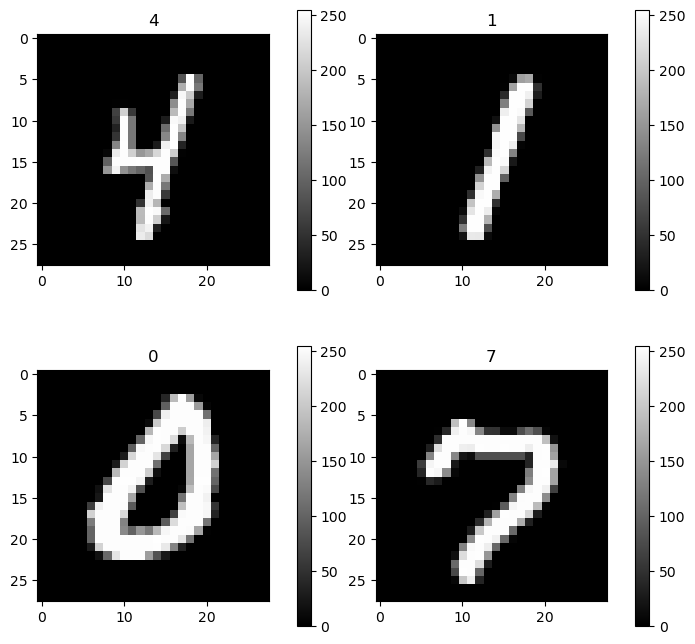

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i, example in enumerate(mnist_dset.take(4)): # We take only 4 examples from the dataset 
    im = ax[i].imshow(example['image'][:,:,0],cmap='gray')
    ax[i].set_title("%d"%example['label'])
    plt.colorbar(im, ax=ax[i], pad=0.1, fraction=0.08)


For our purpose of generative modeling, we only need to grab the image, we don't care about the label, and we are going to preprocess these images as floats and rescale them between 0 and 1 (compared to the standard 0-255 ranges of the gray scale). This can all be done by a preprocessing function:

In [5]:
def normalize_img(example):
    """ Preprocessing function that rescales an image between 0,1
    This pre-processing function will return twice the image because for an 
    autoencoder the target is the same as the input (non supervised learning).
    """
    im = tf.cast(example['image'], tf.float32) / 255.
    return im, im

We can now create a full input pipeline for our 
dataset using this pre-processing function.

In [6]:
batch_size = 128

dataset = mnist_dset.map(normalize_img) # Apply the pre-processing function
dataset = dataset.shuffle(10000)           # Shuffle the data over a given buffer 
dataset = dataset.batch(batch_size)               # Batch the data
# dataset = dataset.repeat(nb_epochs).take(num_epochs * batches_per_epoch)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Pre-fetch the data in parallel

batch_per_epoch = dataset.cardinality().numpy()
batch_per_epoch

469

To learn more about how to use the `tf.data.Datasets` API, check out (https://www.tensorflow.org/guide/data).

Let's sample a batch from our newly created dataset:

## Building a Keras Auto-Encoder


Now that we have access to some data, our first goal will be to create a Convolutional Auto-Encoder, which can compress images (in our case of size 28x28) down to some low dimensional latent representation (for instance 2).

### Encoder

We begin with the encoder. We want to build a function that can create an encoder to compress images down to some dimensionality.
We first chose teh dimension of the latent space, i.e. to how many dimension we compress our input images. Here we set it to two to be able to visualise it:

In [7]:
LS_dim = 2

In [8]:
from tensorflow.keras.layers import Conv2D

The Encoder is just two convolutional layers, and then one dense layer to output the 2 dimensions of the latent space:

In [9]:
X_in = tfk.Input(shape=(28, 28, 1), name='Encoder_Input')
y = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', strides=2, padding='same', name='E_conv1')(X_in)
y = tfkl.Conv2D(16, kernel_size=3, activation='relu', strides=2, padding='same', name='E_conv2')(y)
y = tfkl.Flatten(name='Flattening')(y)
code = tfkl.Dense(LS_dim, name='Code_Prediction')(y)

Encoder = tfk.Model(X_in, code, name='Encoder')

In [10]:
Encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 E_conv1 (Conv2D)            (None, 14, 14, 8)         80        
                                                                 
 E_conv2 (Conv2D)            (None, 7, 7, 16)          1168      
                                                                 
 Flattening (Flatten)        (None, 784)               0         
                                                                 
 Code_Prediction (Dense)     (None, 2)                 1570      
                                                                 
Total params: 2,818
Trainable params: 2,818
Non-trainable params: 0
_________________________________________________________________


In [11]:
tfk.utils.plot_model(Encoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.



### Decoder

The next step is to build an decoder that mirrors the encoder and transforms a vector of low dimensionality back to an image.

In [12]:
decoder_input = tfk.Input(shape=(LS_dim,), name='Decoder_Input')
y = tfkl.Dense(7*7*16, activation='relu', name='Decoder_Dense')(decoder_input) # see the graph above, we want to match the ast shape before the code
y = tfkl.Reshape((7, 7, 16), name='Reshape_to_2D')(y)
y = tfkl.Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same', name='D_conv1')(y)
y = tfkl.Conv2DTranspose(16, kernel_size=3, activation='relu', strides=2, padding='same', name='D_conv2')(y)
reconstructed_img = tfkl.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', strides=1, padding='same', name='D_conv2image')(y)
Decoder = tfk.Model(decoder_input, reconstructed_img, name='Decoder')

In [13]:
Decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 2)]               0         
                                                                 
 Decoder_Dense (Dense)       (None, 784)               2352      
                                                                 
 Reshape_to_2D (Reshape)     (None, 7, 7, 16)          0         
                                                                 
 D_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        4640      
                                                                 
 D_conv2 (Conv2DTranspose)   (None, 28, 28, 16)        4624      
                                                                 
 D_conv2image (Conv2DTranspo  (None, 28, 28, 1)        145       
 se)                                                             
                                                           

In [14]:
tfk.utils.plot_model(Decoder, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Combine the two models

In [15]:
AE_inputs = tfk.Input(shape=(28, 28, 1), name='AE_input')
code = Encoder(AE_inputs)
gen_img = Decoder(code)
AE = tfk.Model(AE_inputs, [gen_img, code], name='Auto Encoder')


In [16]:
AE.summary()

Model: "Auto Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AE_input (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 2)                 2818      
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         11761     
                                                                 
Total params: 14,579
Trainable params: 14,579
Non-trainable params: 0
_________________________________________________________________


In [17]:
tfk.utils.plot_model(AE, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


And just for fun, we can try to see how the decoded images look like:

In [18]:
for batch_imgs, _ in dataset.take(1):
    
    generated_img = AE(batch_imgs)[0]

2024-09-12 17:35:53.512604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-12 17:35:53.512857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-09-12 17:35:53.673943: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

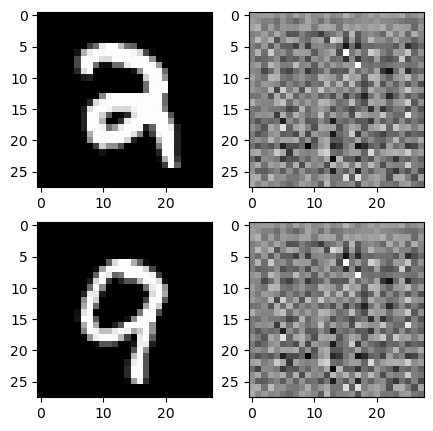

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for i in range(2):
    ax[i, 0].imshow(batch_imgs.numpy()[i], cmap='gray')
    ax[i, 1].imshow(generated_img.numpy()[0], cmap='gray')

Unsurprisingly, we get a bunch of garbage!. Let's try to do some training and see what happens after that.

## Training the Auto-Encoder
### Simple way:

``` python
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.binary_crossentropy)
history = auto_encoder.fit(dset, epochs=10)  # Starts training both encoder and decoder


### Custom way

In [20]:
def train_model(X, loss_fn, optimizer):
    """ with this, tf will automatically record al the info to then compute all gradients and then more the weights with gradient descent """
    with tf.GradientTape() as tape:
        pred = AE(X)[0]
        loss = loss_fn(X, pred)

    gradients = tape.gradient(loss, AE.trainable_variables)
    optimizer.apply_gradients(zip(gradients, AE.trainable_variables))
    return (np.mean(loss.numpy()))  # mean because the loss is computed individually for each instance of the current batch

loss_fn = tfk.losses.MSE # simple mean square error between each x and y
optimizer = tfk.optimizers.RMSprop(learning_rate=5e-3)

losses = []
nb_epochs = 5

for epoch in range(nb_epochs):
    print(f'Epoch {epoch}')
    for i, (batch, _) in enumerate(dataset):
        if i % 200 == 0:
            print(f'{i}th batch over {batch_per_epoch}')
        results = train_model(batch, loss_fn, optimizer)
        losses.append(results)

2024-09-12 17:35:53.786205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-09-12 17:35:53.786495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


Epoch 0
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 1
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 2
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 3
0th batch over 469
200th batch over 469
400th batch over 469
Epoch 4
0th batch over 469
200th batch over 469
400th batch over 469


And that's it, our model should more or less be trained by now. We can check the model history to see what the loss function looks like as a function of training epochs:

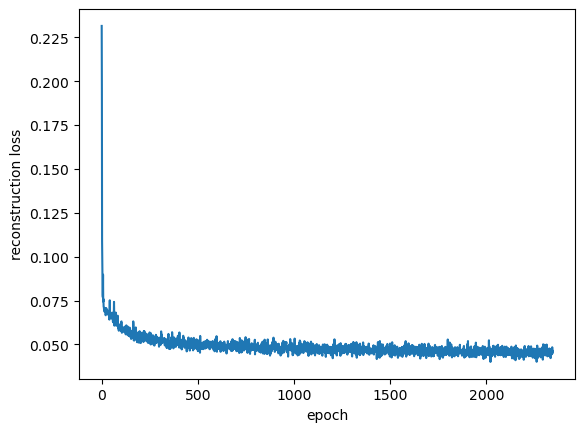

In [21]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('reconstruction loss');

Note that we didnt do validation ! It s bad !!

Now, much more interestingly, we can apply the model on a batch of images and see what comes out:

In [22]:
decoded_images, codes = AE(batch_imgs)

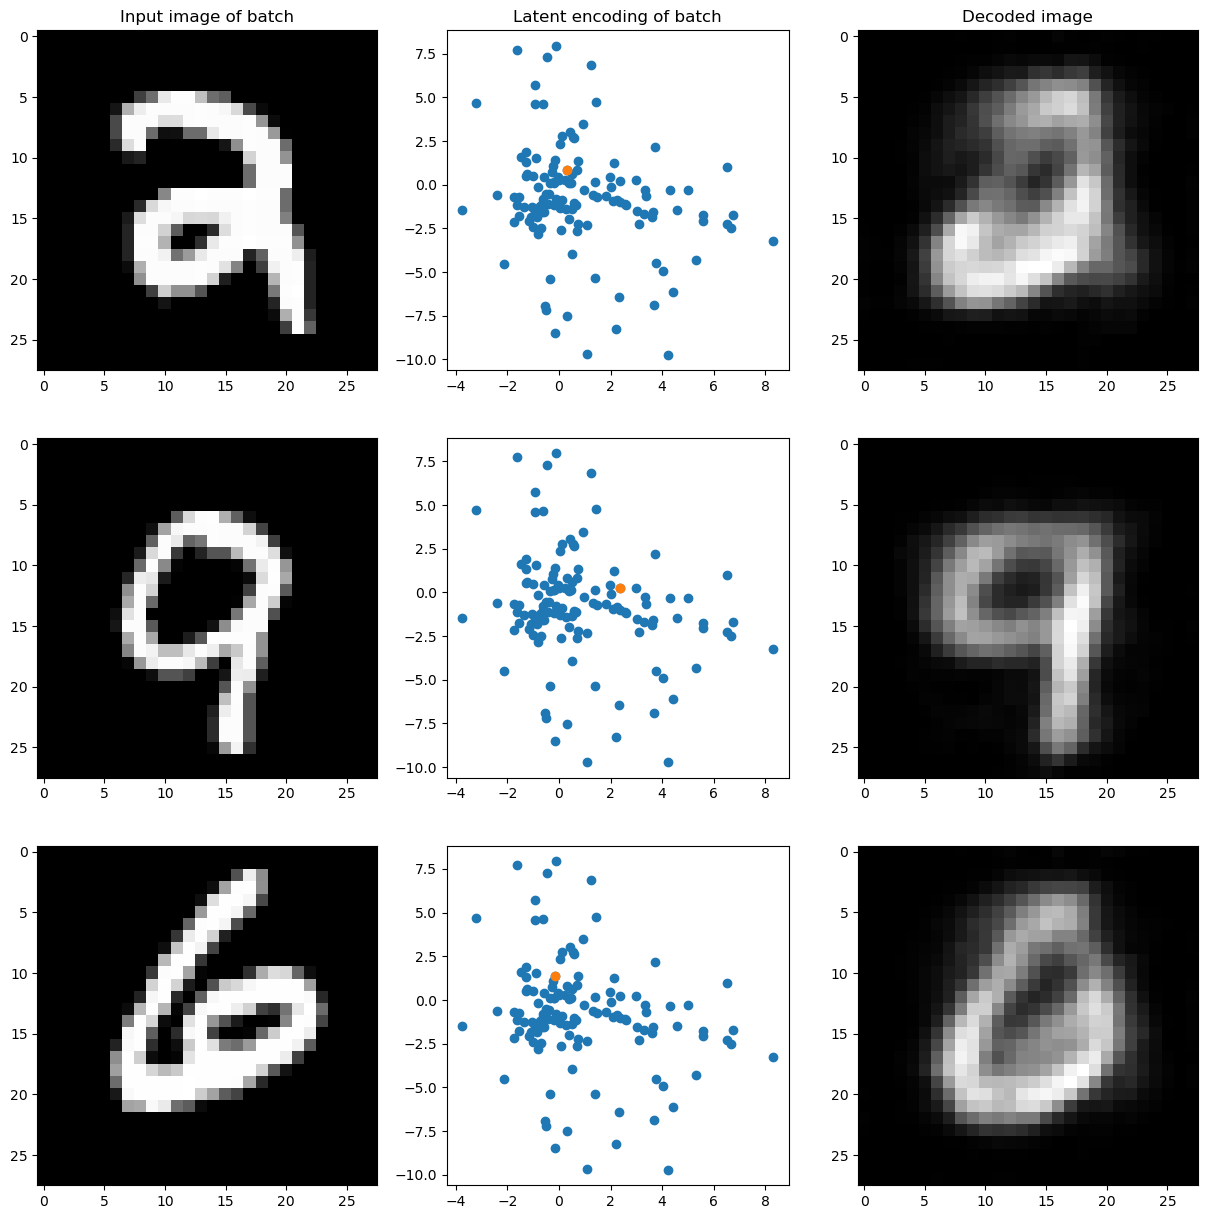

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax[0, 0].set_title('Input image of batch')
ax[0, 1].set_title('Latent encoding of batch')
ax[0, 2].set_title('Decoded image')
for i in range(3):
    ax[i, 0].imshow(batch_imgs[i, :, :, 0],cmap='gray')
    ax[i, 1].scatter(codes[:, 0], codes[:, 1])
    ax[i, 1].scatter(codes[i, 0], codes[i, 1])
    ax[i, 2].imshow(decoded_images[i, :, :, 0],cmap='gray')


In [24]:
mnist_test_dset = tfds.load(name="mnist",
                            split='test')

def normalize_img_test(example):
    """ Normalize images, like during training, but also returns label
    """
    im = tf.cast(example['image'], tf.float32) / 255.
    return im, example['label']

# We build a simplified pipeline for testing
dset_test = mnist_test_dset.map(normalize_img_test)
dset_test = dset_test.batch(1024) # We use a large batch of 1024 examples

#### Visualizing the latent space

We can now have a look at how different digits are encoded in the latent space.

In [25]:
dset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
for batch, labels in dset_test.take(1):
    codes = Encoder(batch)

2024-09-12 17:36:37.540847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-09-12 17:36:37.541143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-09-12 17:36:37.602392: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

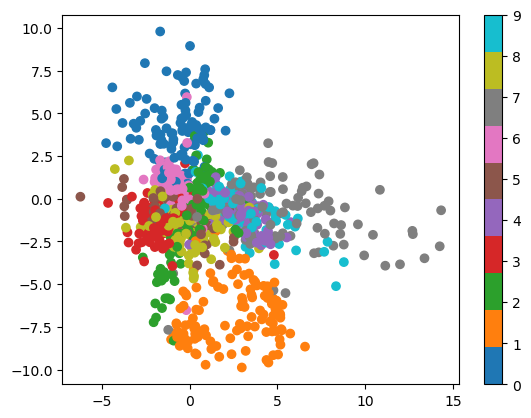

In [27]:
plt.scatter(codes[:, 0], codes[:, 1], c=labels, cmap='tab10');
plt.colorbar() # Plot the encoding

This is not too bad! We recognize some digits, and they are roughly of similar quality as the 
auto-encoded results. **This means that the latent space is fairly regular**, we can sample from it without too much care, but the quality of samples is not great.

In [28]:
# '''use this if working in jupyter'''
# %matplotlib notebook 


In [29]:
# ```python
class Explore_ls:
    def __init__(
        self, 
        fig, 
        ax, 
        codes
    ):

        self.plot_ls = ax[0]  # define the left subplot, where the latent space is plotted
        self.new_samples = [] 
        self.image = ax[1]     # define the right subplot, where the image is created
        self.codes = codes
        fig.canvas.mpl_connect('button_press_event', self)

        # plot the latent space
        self.ls_plot = self.plot_ls.scatter(codes[:, 0],codes[:, 1],c=labels, cmap='tab10')
        self.plot_ls.set_xlabel('z1')
        self.plot_ls.set_ylabel('z2')

        # Reserve some space on top for the title
        fig.subplots_adjust(top=0.8)

    def __call__(self, event):

        click_x = event.xdata
        click_y = event.ydata
        self.plot_ls.set_title(click_x)
        if event.button == 1:
        
            # Create and plot the sample in the LS
            self.new_samples.append(self.plot_ls.scatter(
                event.xdata, 
                event.ydata, 
                marker='*',  # change the marker style to distinguish between sample from the encoded digits
                c='red',     # and the new samples
            ))
            
            # Add info to the title
            self.plot_ls.set_title(f"clicked (z0, z1): ({click_x:.2f}, {click_y:.2f})")
            
            #sample the vector to feed the decoder
            sample = np.reshape([click_x, click_y], (1, 2))
            # feed and run the decoder
            decoded = Decoder(sample)
            # Show the decoded image
            self.image.imshow(decoded[0, :, :, 0], cmap='gray')



In [30]:
%matplotlib widget

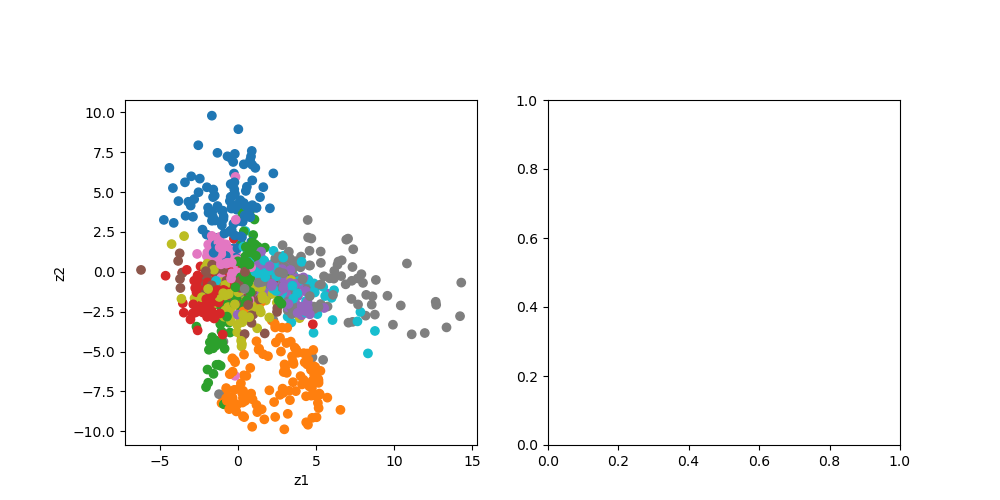

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
interact = Explore_ls(fig, ax, codes)
